In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak

import SBNDstyle
import matplotlib.pyplot as plt
plt.style.use('SBND.mplstyle')
import glob


e_charge=1.60217662e-19
Amplification=498.1985837964828

Bad value in file 'SBND.mplstyle', line 40 ('axes.prop_cycle: cycler("color", ["#E7004C", "#FF9664","#005A8F","#00BBCC","#00CE7C","#3BD4AE","#A1DED2","#8B6969","#DAA8E2",])'): Key axes.prop_cycle: 'cycler("color", ["' is not a valid cycler construction: unterminated string literal (detected at line 1) (<unknown>, line 1)


In [2]:

# file_list = glob.glob('/media/rodrigoa/Andresito/FBK_Preproduccion/247/SET2/SPE/C2--OV45--**')


In [4]:
#try reading the first file

OV=7
# OV=7
# OV=7
print('Reading files...')
file_list = glob.glob('/media/rodrigoa/Andresito/FBK_Preproduccion/247/SET2/SPE/C2--OV'+str(OV)+'--**')

print('Found {} files'.format(len(file_list)))
print('First 3 files names:')
print(file_list[:3])

DEBUG =False

file1_path = file_list[0]
HEADER=3
N_SEGMENTs=50
PRETRIGGER=5e-6 #in s

def SPE_get_ADCs_file(file_path):
    ADCs=np.loadtxt(file_path, delimiter=',', skiprows=5)
    period=ADCs[1,0]-ADCs[0,0]
    ADCs=ADCs[:,1]
    return ADCs,period

    
def SPE_get_ADCs_file_list(file_list,polarity=1,PED_RANGE=250):
    ADCs_list=[]
    for file_path in file_list:
        ADCs,period=SPE_get_ADCs_file(file_path)
        ADCs_list.append(ADCs)
    ADCs=np.array(ADCs_list)
    
    ADCs = (ADCs.T - np.mean(ADCs[:, :PED_RANGE], axis=1).T).T
    ADCs*=polarity
    return ADCs,period


ADCs, period= SPE_get_ADCs_file_list(file_list)

# DEBUG=True
if DEBUG:
    for i in range(10):
        plt.plot(ADCs[i,:])
        
    plt.figure()
    avg_ADCs=np.mean(ADCs,axis=0)
    plt.plot(avg_ADCs)
    plt.semilogy()

Reading files...
Found 10215 files
First 3 files names:
['/media/rodrigoa/Andresito/FBK_Preproduccion/247/SET2/SPE/C2--OV7--02115.txt', '/media/rodrigoa/Andresito/FBK_Preproduccion/247/SET2/SPE/C2--OV7--06467.txt', '/media/rodrigoa/Andresito/FBK_Preproduccion/247/SET2/SPE/C2--OV7--00000.txt']


In [6]:
from scipy.optimize import curve_fit

#functions:
def gauss(x,a,x0,sigma):
    return a*np.exp(-0.5*np.power((x-x0)/sigma,2))

def gaussian_train(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        height = params[i]
        center = params[i+1]
        width  = params[i+2]
        y      +=  gauss(x, height, center, width)
    return y

def fit_gaussians(x, y, *p0):
    assert x.shape == y.shape, "Input arrays must have the same shape."
    # try:
    popt, pcov = curve_fit(gaussian_train, x,y, p0=p0[0])
    fit_y=gaussian_train(x,*popt)
    chi_squared = np.sum((y[abs(fit_y)>0.1] - fit_y[abs(fit_y)>0.1]) ** 2 / fit_y[abs(fit_y)>0.1]) / (y.size - len(popt))
    # plt.figure(dpi=200, figsize=(6, 3))
    # fig = plt.axes()
    # plt.plot(x, y, 'b-', label='data')
    # plt.plot(x, fit_y, 'r-', label='fit',linewidth=1)
    # plt.grid()
    return popt,fit_y, chi_squared
    # except:
    #     print("Fit failed.")
    
def Q_out(V_out,period):
    #   V_out in Volts
    #          osc resistance    x  t
    q=V_out  /      50          *   period
    return q



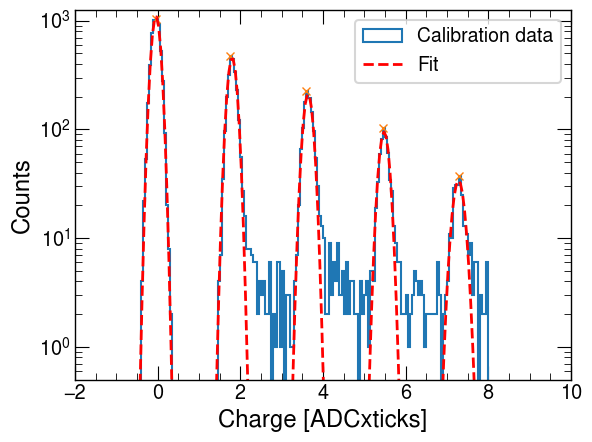

In [7]:
charge= np.sum(ADCs[:,200:],axis=1)


from scipy.signal import find_peaks
# Find peaks in the charge histogram
peaks, _ = find_peaks(charge, height=50)

# plt.hist(charge3,bins=300,histtype='step');

# plt.semilogy()

plt.xlim(-2,10)

# plt.semilogy()
Bins=200
r=[-2,8]



counts,bins,_=plt.hist(charge ,bins=Bins,range=r,histtype='step',label="Calibration data");

#find peaks
peaks=find_peaks(counts,height=10,width=1)
plt.plot(bins[peaks[0]], counts[peaks[0]], "x")

#right limit:(supossing same space between peaks, prevents adding more gaussians that the ones considered to be fitted)
r_lim=peaks[0][-1]+ int (((peaks[0][-1]-peaks[0][-2]))/2)

l_lim=peaks[0][0]- int (((peaks[0][1]-peaks[0][0]))/2)-2

std=(bins[peaks[0]][1]-bins[peaks[0]][0])/4

params=np.zeros(len(peaks[0])*3)
params[0::3]=peaks[1]["peak_heights"]
params[1::3]=bins[peaks[0]]
params[2::3]=std

vars,fit_y,qs=fit_gaussians(bins[:-1][l_lim:r_lim],counts[l_lim:r_lim],params)

plt.plot(bins[:-1][l_lim:r_lim] +(bins[1]-bins[0])/2  ,fit_y,'--',color="red",label="Fit")
plt.legend()
plt.xlabel("Charge [ADCxticks]")
plt.ylabel("Counts")
# plt.xlim( bins[peaks[0]][0]-2*half,bins[peaks[0]][-1]+5*half)

x = bins[:-1][l_lim:r_lim] + (bins[1] - bins[0]) / 2

# for i in range(0, len(vars), 3):
#     height = vars[i]
#     center = vars[i + 1]
#     width = vars[i + 2]
#     gaussian = gauss(x, height, center, width)
#     plt.plot(x, gaussian, color="tab:green")

plt.ylim(0.5,counts[peaks[0]][0]*1.2)

plt.legend(frameon=True,fontsize=14)
plt.savefig("Finger_plot_"+str(OV)+".png",dpi=300)
plt.semilogy()
plt.savefig("Finger_plot_log_"+str(OV)+".png",dpi=300)


In [32]:
##save the data

import os
import pandas as pd
gain_ADCs_x_ticks     = np.mean(vars[1::3][1:]-vars[1::3][:-1])
gain_ADCs_x_ticks_std = np.std (vars[1::3][1:]-vars[1::3][:-1])
error_relative=gain_ADCs_x_ticks/gain_ADCs_x_ticks_std

gain_absolute=Q_out(gain_ADCs_x_ticks,period)/e_charge/1e6/Amplification
gain_absolute_error=gain_absolute*error_relative


file_path = 'calibrations.csv'  # Replace with the actual file path

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    df = pd.DataFrame({'OV': [], 'Gain': [],"Error":[],"Relative":[]})  # Replace with your desired dataframe creation code

# Add a new row to the dataframe
new_row = {'OV': OV, 'Gain': gain_absolute, 'Error': gain_absolute_error, 'Relative': error_relative}

df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


df.to_csv(file_path, index=False)
